In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score


In [2]:
# Load the training dataset
data  = pd.read_csv("UNSW_NB15_training-set.csv")

# Display the first 5 rows
data .head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
# Checking the data

# Check the number of rows and columns
print("Dataset shape:", data .shape)

# Show all column names
print("\nColumns:")
print(data .columns)

# Count how many samples belong to each attack category
print("\nAttack categories:")
print(data ['attack_cat'].value_counts())

# Count how many samples are normal vs attack
print("\nLabels (0 = Normal, 1 = Attack):")
print(data ['label'].value_counts())

Dataset shape: (175341, 45)

Columns:
Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

Attack categories:
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

Labels (0 = Normal, 1 = Attack):
label
1    119341
0     56000
Name: 

In [4]:
# Cleaning and preparing data

# Make a copy of the original file

df = data .copy()

# Remove any columns that the ML Model cannot use like text
df = df.drop(['id', 'attack_cat'], axis=1)

# Quick check of remaining columns
print("Remaining columns:", df.columns)

Remaining columns: Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')


In [5]:
# Encode text

# Columns with text that must be converted to numbers
text_columns = ['proto', 'service', 'state']

# Create a LabelEncoder and apply it to each text column
label_enc = LabelEncoder()

for col in text_columns:
    df[col] = label_enc.fit_transform(df[col])

# Preview the first few encoded values
df[text_columns].head()

,proto,service,state
0,113,0,2
1,113,0,2
2,113,0,2
3,113,3,2
4,113,0,2


In [6]:
# Feature Splitting with X and y labels

X = df.drop('label', axis=1)
y = df['label']

print("X shape:", X.shape)
print("Y shape:", y.shape)

X shape: (175341, 42)
Y shape: (175341,)


In [7]:
# Splitting data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (122738, 42)
Testing set: (52603, 42)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Perform hyperparameter tuning for the XGBoost model. Instead of manually guessing each parameter 

# Define the parameter search space for XGBoost
params = {
    'max_depth': [6, 7, 8, 9, 10],           # How deep each tree can grow (controls model complexity)
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size for updating tree weights (lower = more stable)
    'n_estimators': [300, 500, 800, 1000],   # Number of boosting rounds (more = stronger model)
    'subsample': [0.6, 0.8, 1.0],            # Fraction of rows sampled per tree (prevents overfitting)
    'colsample_bytree': [0.6, 0.8, 1.0],     # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],                  # Minimum loss reduction required for further splits
    'reg_lambda': [1, 2, 3]                  # L2 regularization to reduce overfitting
}

# Create a base XGBoost model
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1
)

# RandomizedSearchCV tries random parameter combinations from the grid abov
search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    n_iter=100,
    scoring='f1',
    cv=3,
    verbose=2
)
# Fit the search object on the training data
search.fit(X_train_scaled, y_train)

print("Best params:", search.best_params_)

In [10]:
# These are some of the results from running the hyperparameter tuning
param_sets = {
    "best_params1": {
        'subsample': 1.0,
        'reg_lambda': 2,
        'n_estimators': 500,
        'max_depth': 9,
        'learning_rate': 0.2,
        'gamma': 0.1,
        'colsample_bytree': 1.0
    },
    "best_params2": {
        'subsample': 1.0,
        'reg_lambda': 3,
        'n_estimators': 800,
        'max_depth': 8,
        'learning_rate': 0.05,
        'gamma': 0.1,
        'colsample_bytree': 1.0
    },
    "best_params3": {
        'subsample': 1.0,
        'reg_lambda': 1,
        'n_estimators': 300,
        'max_depth': 10,
        'learning_rate': 0.1,
        'gamma': 0.1,
        'colsample_bytree': 0.8
    },
    "best_params4": {
        'subsample': 1.0,
        'reg_lambda': 1,
        'n_estimators': 500,
        'max_depth': 10,
        'learning_rate': 0.05,
        'gamma': 0,
        'colsample_bytree': 1.0
    },
    "best_params5": {
        'subsample': 1.0,
        'reg_lambda': 3,
        'n_estimators': 500,
        'max_depth': 10,
        'learning_rate': 0.05,
        'gamma': 0.2,
        'colsample_bytree': 1.0
    }
}

results = {}




In [11]:
# The best parameter found
best_params = {
    'subsample': 1.0,
    'reg_lambda': 1,
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.05,
    'gamma': 0,
    'colsample_bytree': 1.0
}


In [12]:
# Loop through the sets of the trained models and find the best

for name, params in param_sets.items():
    print(f"\n🔵 Training model: {name}")
    # Create an XGBoost model using the current parameter set
    model = xgb.XGBClassifier(
        **params,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = (accuracy, f1)

    print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

# Print a comparison of all models
print("\n============================")
print("FINAL COMPARISON OF MODELS:")
print("============================")
for name, scores in results.items():
    print(f"{name}: Accuracy={scores[0]:.4f}, F1={scores[1]:.4f}")


🔵 Training model: best_params1
Accuracy: 0.9612, F1-score: 0.9716

🔵 Training model: best_params2
Accuracy: 0.9605, F1-score: 0.9711

🔵 Training model: best_params3
Accuracy: 0.9616, F1-score: 0.9719

🔵 Training model: best_params4
Accuracy: 0.9620, F1-score: 0.9722

🔵 Training model: best_params5
Accuracy: 0.9604, F1-score: 0.9711

FINAL COMPARISON OF MODELS:
best_params1: Accuracy=0.9612, F1=0.9716
best_params2: Accuracy=0.9605, F1=0.9711
best_params3: Accuracy=0.9616, F1=0.9719
best_params4: Accuracy=0.9620, F1=0.9722
best_params5: Accuracy=0.9604, F1=0.9711


In [13]:
# Build final tuned model
xgb_best = xgb.XGBClassifier(
    **best_params,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Train
xgb_best.fit(X_train_scaled, y_train)

# Predict
y_pred_best = xgb_best.predict(X_test_scaled)

# Evaluate
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Tuned XGBoost Accuracy: 0.9619793547896508
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     16800
           1       0.97      0.98      0.97     35803

    accuracy                           0.96     52603
   macro avg       0.96      0.95      0.96     52603
weighted avg       0.96      0.96      0.96     52603

Confusion Matrix:
 [[15587  1213]
 [  787 35016]]


In [14]:
# Train Random Forest Model

rf = RandomForestClassifier(
    n_estimators=300, # Number of decision trees
    class_weight='balanced', # To help againts data inbalance
    n_jobs=-1, # Use all CPU cores
    random_state=42 # Random number generator
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Evaluate the model

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}\n")
print("classification report: \n", classification_report(y_test, y_pred))
print ("Confusion matrix: \n", cm)


Accuracy: 0.9585

classification report: 
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     16800
           1       0.96      0.98      0.97     35803

    accuracy                           0.96     52603
   macro avg       0.96      0.95      0.95     52603
weighted avg       0.96      0.96      0.96     52603

Confusion matrix: 
 [[15423  1377]
 [  808 34995]]


In [16]:
"""
This code calculates the ROC-AUC score for both the Random Forest model and the 
final tuned XGBoost model. ROC-AUC measures how well each model separates the 
two classes (normal vs. attack). A higher ROC-AUC value means better 
discrimination capability.

predict_proba() returns the probability that a given sample belongs to a class.
We take the probability of class 1 (attack) and evaluate how well the model 
distinguishes attacks from normal traffic.
"""

# Random Forest ROC-AUC 

# Check if the Random Forest model supports probability predictions
if hasattr(rf, "predict_proba"):
    
    # Predict probabilities for the attack class (class 1)
    y_prob = rf.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate ROC-AUC using true labels and predicted probabilities
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"Random Forest ROC-AUC: {auc:.4f}")


# XGBoost ROC-AUC

# Check if the final tuned XGBoost model supports predict_proba()
if hasattr(xgb_best, "predict_proba"):
    
    # Predict probabilities for the attack class (class 1)
    y_prob_xgb = xgb_best.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate ROC-AUC for XGBoost
    auc_xgb = roc_auc_score(y_test, y_prob_xgb)
    
    print(f"XGBoost ROC-AUC: {auc_xgb:.4f}")

else:
    # Only triggered if model has no predict_proba() method
    print("XGBoost model does not support predict_proba()")

ROC-AUC: 0.9938
XGBoost ROC-AUC: 0.9945


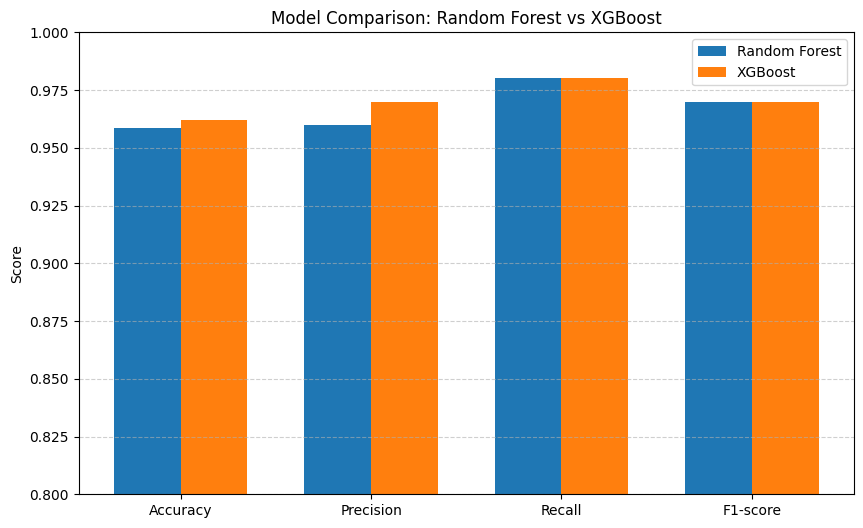

In [17]:
# Random Forest
rf_accuracy = 0.9585
rf_precision = 0.96
rf_recall = 0.98
rf_f1 = 0.97

# XGBoost
xgb_accuracy = 0.9619
xgb_precision = 0.97
xgb_recall = 0.98
xgb_f1 = 0.97

# ===========================
# Graph Data Setup
# ===========================

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]
xgb_scores = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]

x = np.arange(len(metrics))
width = 0.35

# ===========================
# Plotting
# ===========================

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rf_scores, width, label='Random Forest')
plt.bar(x + width/2, xgb_scores, width, label='XGBoost')

plt.xticks(x, metrics)
plt.ylim(0.80, 1.00)
plt.ylabel("Score")
plt.title("Model Comparison: Random Forest vs XGBoost")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [18]:
# Save the best model and the scaler to a file to use later
joblib.dump(xgb_best, "xgboost_ids_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']